# Knowledge Survival Model
## Lindy Effect / Pareto Model
- $S(t)=qS_\text{Lindy}(t)+(1-q)S_\text{Jump}(t)$
  - Jump handles "big-bang" epistemic resets.
  - $S_\text{Jump}$ seems like the emergence of a competing truth.
  - Draw the *life-length* $\tau$ from this mixture $S(t)$ once, at $t=0$
    - $I_t=
          \begin{cases}
              1, t<\tau\\
              0, t\ge\tau
          \end {cases}$
  - $S(t)$ measures two thresholds:
    - **Truth collapse threshold** $\theta_\text{truth}$ (e.g., $T_t \le 0.1$)
    - **Utility collapse threshold** $\theta_\text{util}$ (e.g., $U_t \le 0.05 \times U_0$)
    - $\tau$ is the first hitting time of either threshold or an exogenous paradigm-shifting event.
      - The empirical $S(t)$ then becomes the survival curve of "value above minimal relevance."
      - In practice:
        - Simulate $T_t$ and $U_t$
        - Set $\tau = \text{inf}\{t:T_t\le\theta_\text{truth} \text{ or } U_t\le\theta_\text{util}\}$
    - Estimate $S(t)$ non-parametrically from historical citation-decay data and then blend Lindy tails for the far relevance horizon.

In [1]:
import pandas as pd

pd.set_option('display.max_rows', None)  # `None` means displaying all rows
pd.set_option('display.max_columns', None)

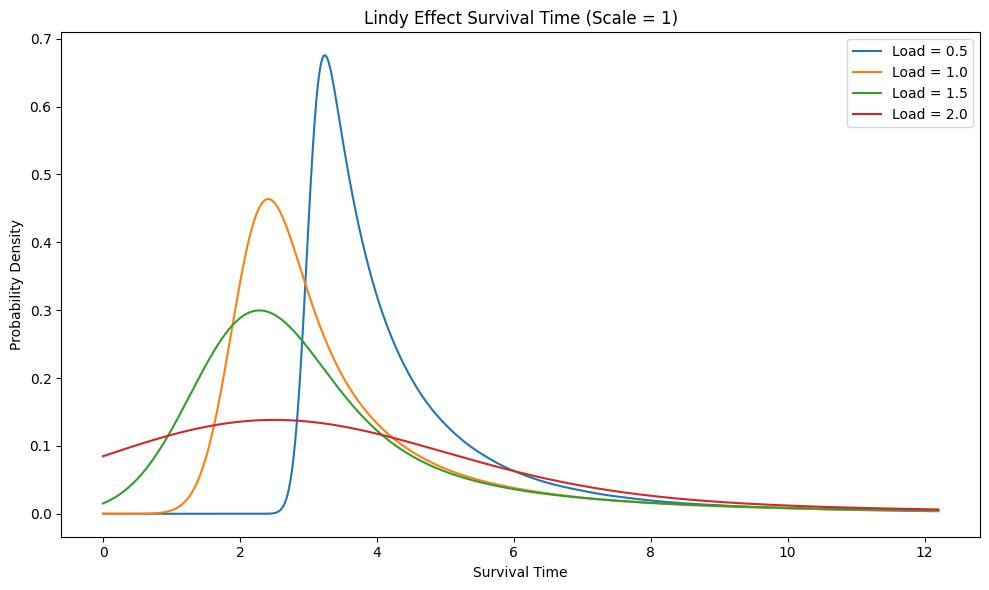

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import pareto


# Generate Lindy Effect Survival data
def generate_lindy_effect_data(n_sims=10_000, load=1, scale=1):
    scale = (1+load)/load

    # Generate Pareto-distributed data
    data = pareto.rvs(scale, size=n_sims, scale=scale)
    
    # # Create a DataFrame to hold the data
    # df = pd.DataFrame(data, columns=['Survival Time'])
    
    # # Calculate the Lindy Effect (logarithm of survival time)
    # df['Lindy Effect'] = np.log(df['Survival Time'])
    
    return data

n_sims = 100_0000

# Simulate Linde Effect
truth_param_list = [0.5, 1.0, 1.5, 2.0]
lindy_sims = [generate_lindy_effect_data(n_sims=n_sims, load=load) for load in truth_param_list]
density_list = [stats.gaussian_kde(sim) for sim in lindy_sims]

# Plot the Lindy Effect Survival data
plt.figure(figsize=(10, 6))
x = np.linspace(0, max([np.percentile(sim, 95) * 1.1 for sim in lindy_sims]), 1000)
for idx, load in enumerate(truth_param_list):
    plt.plot(x, density_list[idx](x), label=f'Load = {load}')
plt.legend(loc='best')
plt.title('Lindy Effect Survival Time (Scale = 1)')
plt.xlabel('Survival Time')
plt.ylabel('Probability Density')
plt.tight_layout()
plt.show()


## Modeling Decay/Distortion
- "Deterioration + shock" framework
- Components:
  - Erosion (slow blur of knowledge)
    - Erosion $D_t$ is Gamma with mean drift $\alpha t$
  - Recovery (restoration)
  - Shocks (misinformation events)
    - Compound Negative Binomial $\sum_{i=1}^{N_t}Z_i$ where $Z_i \sim \text{Lognormal/Pareto}$
- Truth level $T_t \sim e^{-D_t+\text{Recovery}_t-J_t}$ clipped at $[0, 1]$.
  - $J_t=\sum_i^{N_t} Z_i$ where $N_t\sim \text{NegBin}(\lambda t)$ representing misinformation shocks.
    - $N_t$ will be modeled as discrete annual shocks

### Monthly Truth Level Simulation

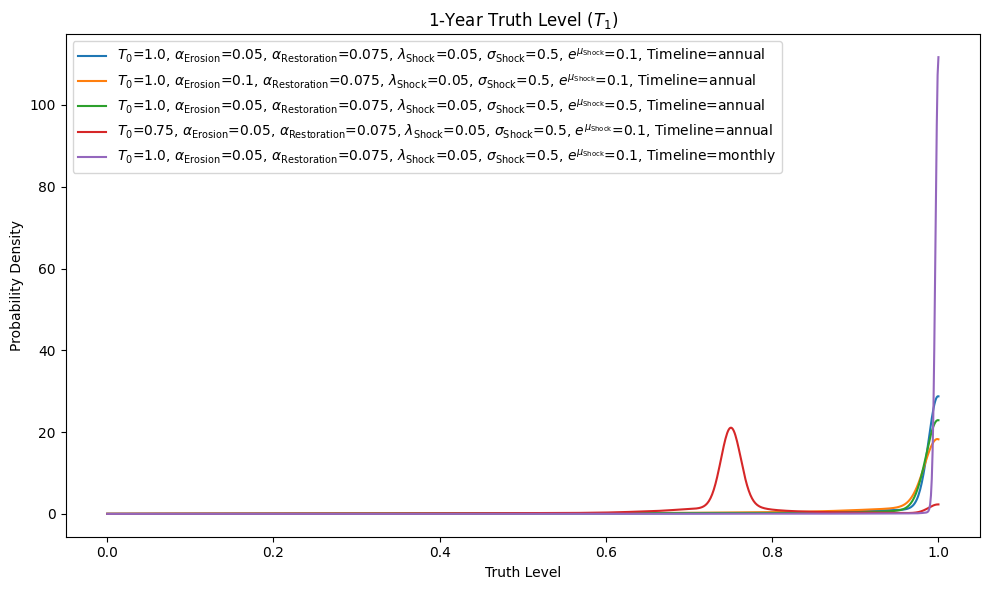

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import gamma, nbinom, lognorm


truth_level_params = [r"$T_0$",
                    r"$\alpha_\text{Erosion}$",
                    r"$\alpha_\text{Restoration}$",
                    r"$\lambda_\text{Shock}$",
                    r"$\sigma_\text{Shock}$",
                    r"$e^{\mu_\text{Shock}}$",
                    r"Timeline"]


def sim_truth_level(
        starting_truth,
        erosion_shape,
        restoration_shape,
        shock_λ,
        shock_σ,
        shock_scale,
        timeline='annual',  # can be 'annual' or 'monthly'
        n_sims=10_000
):
    """
    Simulate the Truth Level of knowledge over time using a combination of erosion, restoration, and shock events.

    Parameters:
    - starting_truth: Initial truth level (0 to 1).
    - erosion_shape: Shape parameter for the gamma distribution representing erosion.
    - restoration_shape: Shape parameter for the gamma distribution representing restoration.
    - shock_λ: Shock frequency input for the Poisson model.
    - shock_σ: Standard deviation of the log-normal distribution representing shock severity.
    - shock_scale: Scale parameter of the log-normal distribution representing shock severity.
    - timeline: 'annual' or 'monthly' to indicate the simulation time frame.
    - n_sims: Number of simulations to run.


    Returns:
    - truth_level: Simulated truth level after the specified time period.


    Notes:
    - Parameters must be supplied annualized, even when running monthly simulations.
    """
    if timeline not in ['annual', 'monthly']:
        raise ValueError("Timeline must be either 'annual' or 'monthly'.")

    if timeline == 'annual':
        # Simulate truth drift using a gamma distribution
        erosion_shape = gamma.rvs(erosion_shape, scale=1.0, size=n_sims)

        # Simulate the restoration rate using a gamma distribution
        recovery_rate = gamma.rvs(restoration_shape, scale=1.0, size=n_sims)

        # Simulate the number of shocks using a poisson distribution
        annual_shocks = stats.poisson.rvs(shock_λ, size=n_sims)

        max_shocks = int(annual_shocks.max())
        shock_event_idx = np.arange(max_shocks)
        shock_event_mask = shock_event_idx[None, :] < annual_shocks[:, None]

        # Simulate the amount of shocks using a log-normal distribution
        shock_severities = lognorm.rvs(
            shock_σ, scale=shock_scale, size=(n_sims, max_shocks))
        total_shocks = np.zeros((n_sims, max_shocks))
        total_shocks[shock_event_mask] = shock_severities[shock_event_mask]
        total_shock_rate = total_shocks.sum(axis=1)

        # Combine the effects
        truth_level = starting_truth * \
            np.exp(-erosion_shape + recovery_rate - total_shock_rate)

        # Ensure the truth level is between 0 and 1
        truth_level = np.clip(truth_level, 0.0, 1.0)

        return truth_level
    elif timeline == 'monthly':
        # Simulate truth drift using a gamma distribution
        erosion_shape = gamma.rvs(erosion_shape / 12.0, scale=1.0, size=n_sims)

        # Simulate the restoration rate using a gamma distribution
        recovery_rate = gamma.rvs(
            restoration_shape / 12.0, scale=1.0, size=n_sims)

        # true Poisson thinning for shocks
        monthly_lambda = shock_λ * (1.0 / 12.0)
        monthly_shocks = stats.poisson.rvs(monthly_lambda, size=n_sims)

        if monthly_shocks.size == 0:
            total_shock_rate = 0
        else:
            max_shocks = int(monthly_shocks.max())
            shock_event_idx = np.arange(max_shocks)
            shock_event_mask = shock_event_idx[None, :] < monthly_shocks[:, None]

            # Simulate the amount of shocks using a log-normal distribution
            shock_severities = lognorm.rvs(
                shock_σ, scale=shock_scale, size=(n_sims, max_shocks))
            total_shocks = np.zeros((n_sims, max_shocks))
            total_shocks[shock_event_mask] = shock_severities[shock_event_mask]
            total_shock_rate = total_shocks.sum(axis=1)

        # Combine the effects
        truth_level = starting_truth * \
            np.exp(-erosion_shape + recovery_rate - total_shock_rate)

        # Ensure the truth level is between 0 and 1
        truth_level = np.clip(truth_level, 0.0, 1.0)

        return truth_level
    else:
        raise ValueError("Timeline must be either 'annual' or 'monthly'.")


n_sims = 100_000

truth_params_list = [(1.0, 0.05, 0.075, 0.05, 0.5, 0.1, 'annual'),
                    (1.00, 0.10, 0.075, 0.05, 0.5, 0.1, 'annual'),
                    (1.00, 0.05, 0.075, 0.05, 0.5, 0.5, 'annual'),
                    (0.75, 0.05, 0.075, 0.05, 0.5, 0.1, 'annual'),
                    (1.00, 0.05, 0.075, 0.05, 0.5, 0.1, 'monthly')]

# Simulate Truth Level
truth_level_sims = [sim_truth_level(*params, n_sims=n_sims)
                    for params in truth_params_list]
truth_level_kde_list = [stats.gaussian_kde(sim) for sim in truth_level_sims]

# Plot the Truth Level simulation data
plt.figure(figsize=(10, 6))
x = np.linspace(0.0, 1.0, 1000)
for idx, truth_level_dist in enumerate(truth_level_kde_list):
    param_label = ", ".join([f'{truth_level_params[param]}={truth_params_list[idx][param]}' for param in range(
        len(truth_params_list[idx]))])
    plt.plot(x, truth_level_dist(x), label=param_label)
plt.legend(loc='best')
plt.title('1-Year Truth Level ($T_1$)')
plt.xlabel('Truth Level')
plt.ylabel('Probability Density')
plt.tight_layout()
plt.show()

## Utility & Value
- $V_t=I_t\times U_t\times T_t\times R_t$
  - $V_t$ = Value of knowledge
  - $I_t$ = binary survival of the idea, defined above, measured using $S(t)$
    - $1$ or $0$
  - $U_t$ = Usefulness, maybe a mean-reverting process reflecting how often the knowledge is referenced in decisions.
    - $\ge0$
    - $U_t=\alpha\text{CiteVel}_t+\beta\text{SearchHits}_t$
      - Citation velocity via arXiv / CrossRef API (monthly new citations).
        - Similarly monthly search hits
      - Maybe add down-trend factor when newer competing papers appear.
    - Model as **Ornstein-Uhlenbeck:**
      - $dU_t=\kappa(\bar{U}-U_t)dt+\sigma_U dW_t$
        - mean level $\bar{U}$ itself can drift downward if $T_t$ falls sharply (credibility drag)
  - $T_t$ = Truth level, as above.
    - $\in[0, 1]$
  - $R_t$ = Replaceability (cost to re-learn).
    - $>0$
    - $(0,1)$ for easy
    - $1$ for baseline
    - $>1$ for hard
- Net Present-Value: $\text{NPV} = \int_0^\infty e^{-rt}V_tdt$
  - Exposure base for the Premium

### Utility Model
- Model as **Ornstein-Uhlenbeck:**
    - $dU_t=\kappa(\bar{U}-U_t)dt+\sigma_U dW_t$
    - mean level $\bar{U}$ itself can drift downward if $T_t$ falls sharply (credibility drag)
    - This process at any $t$ is normal with:
      - $\mathbb{E}[U_t]=\bar{U}+(U_0 - \bar{U})e^{-\kappa t}$
      - $\text{Var}[U_t]=\frac{\sigma^2_U}{2\kappa}(1-e^{-2\kappa t})$

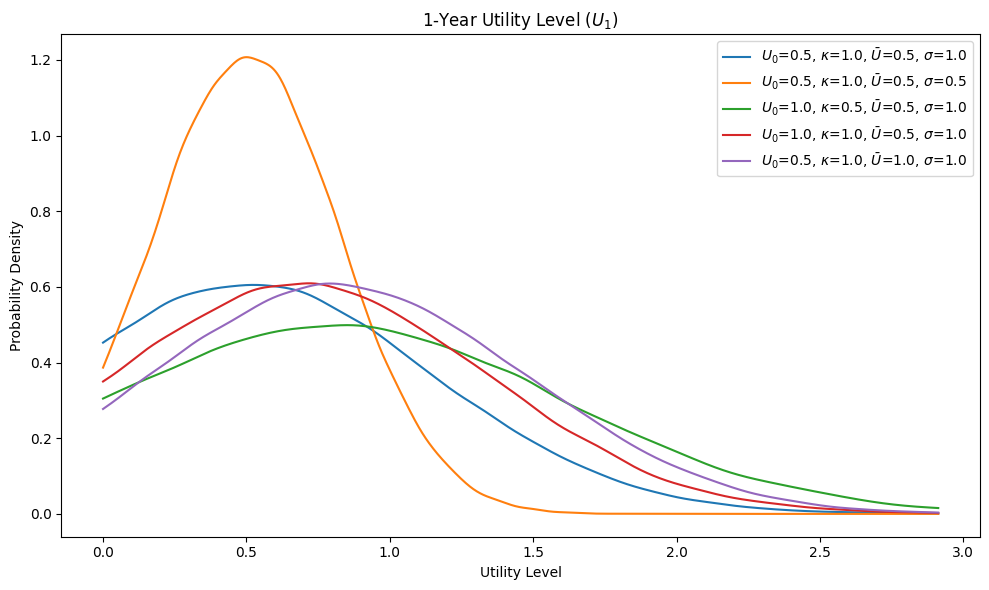

In [ ]:
util_level_params = [r"$U_0$", 
                    r"$\kappa$", 
                    r"$\bar{U}$", 
                    r"$\sigma$"]

def sim_util(
        U0,           # starting value
        κ,            # mean-reversion speed
        U_bar,        # long-run mean
        σ,            # volatility
        t = 1.0,      # horizon (year)
        n_sims=10_000 # Monte-Carlo draws
):
    """
    Simulate the Utility Level of knowledge over time using a mean-reverting process.
    Implements the Ornstein-Uhlenbeck process.

    
    Parameters:
    - U0: Initial utility level >=0.
    - κ: Mean-reversion speed >=0.
    - U_bar: Long-run mean utility level >=0.
    - σ: Volatility of the utility level >0.
    - t: Time horizon (in years).
    - n_sims: Number of simulations to run.


    Returns:
    - Ut_dist: Simulated utility level after the specified time period.
    """
    theoretical_mean = U_bar + (U0 - U_bar) * np.exp(-κ * t)
    theoretical_var = σ ** 2 / (2 * κ) * (1 - np.exp(-2 * κ * t))
    Ut_dist = stats.norm.rvs(loc=theoretical_mean, scale=np.sqrt(theoretical_var), size=n_sims)
    return Ut_dist

n_sims = 100_000

util_params_list = [(0.5, 1.0, 0.5, 1.0),
                    (0.5, 1.0, 0.5, 0.5),
                    (1.0, 0.5, 0.5, 1.0),
                    (1.0, 1.0, 0.5, 1.0),
                    (0.5, 1.0, 1.0, 1.0)]

# Simulate Truth Level
util_level_sims = [sim_util(*params, n_sims=n_sims) for params in util_params_list]
util_level_kde_list = [stats.gaussian_kde(sim) for sim in util_level_sims]

# Plot the Utility simulation data
plt.figure(figsize=(10, 6))
x = np.linspace(0, max([np.percentile(sim, 99) * 1.1 for sim in util_level_sims]), 1000)
for idx, util_level_dist in enumerate(util_level_kde_list):
    param_label = ", ".join([f'{util_level_params[param]}={util_params_list[idx][param]}' for param in range(len(util_params_list[idx]))])
    plt.plot(x, util_level_dist(x), label=param_label)
plt.legend(loc='best')
plt.title('1-Year Utility Level ($U_1$)')
plt.xlabel('Utility Level')
plt.ylabel('Probability Density')
plt.tight_layout()
plt.show()

### Calculate Net Present-Value
- $\text{NPV} = \int_0^\infty e^{-rt}V_tdt$
  - Exposure base for the Premium
- TODO: Why is the NPV so low? It should be about 20x more
  - Is there an inaccurate accounting for dt?

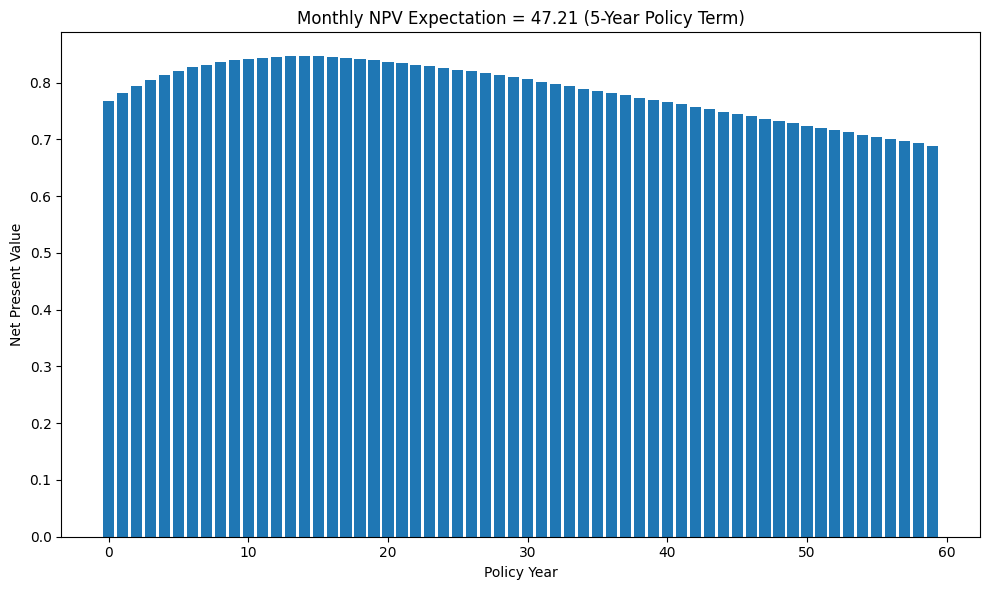

In [23]:
def calculate_value(
    utility_params,  # Utility parameters (U0, kappa, U_bar, sigma)
    starting_truth,  # Starting truth level (T0)
    # Truth parameters (T0, alpha_erosion, alpha_restoration, r_shock, p_shock, sigma_shock, scale_shock)
    truth_params,
    replaceability=1.0,  # Cost to re-learn (1.0 is baseline, >1 is hard)
    years=5,  # Time horizon (in integer years)
    n_sims=10_000  # Number of Monte Carlo simulations
):
    """
    Calculate the value over time V_t of a covered piece of knowledge.
    This serves as the policy exposure.

    Returns:
    - monthly_all: shape (years * 12, n_sims) of all sim paths
    """
    n_months = int(years * 12)
    dt = 1 / 12.0

    # unpack
    U0 = utility_params['U0']
    kappa = utility_params['kappa']
    U_bar = utility_params['U_bar']
    sigma = utility_params['sigma']

    erosion_shape = truth_params['erosion_shape']
    restoration_shape = truth_params['restoration_shape']
    shock_lambda = truth_params['shock_lambda']
    shock_sigma = truth_params['shock_sigma']
    shock_scale = truth_params['shock_scale']

    # initialize arrays to track simulations
    util = np.full(n_sims, U0)
    truth = np.full(n_sims, starting_truth)

    # pre-allocate
    monthly_all = np.zeros((n_months, n_sims))
    util_all = np.zeros((n_months, n_sims))
    truth_all = np.zeros((n_months, n_sims))

    for month in range(n_months):
        # OU step for U
        dW = np.random.randn(n_sims) * np.sqrt(dt)
        util += kappa * (U_bar - util) * dt + sigma * dW

        # truth step
        truth = sim_truth_level(
            truth,
            erosion_shape,
            restoration_shape,
            shock_lambda,
            shock_sigma,
            shock_scale,
            timeline='monthly',
            n_sims=n_sims
        )

        # track NPV for each sim
        monthly_all[month] = util * truth * replaceability
        util_all[month] = util
        truth_all[month] = truth

    # average across sims
    monthly_mean = monthly_all.mean(axis=1)
    return monthly_all, util_all, truth_all

def calculate_exposure(
    discount_rate,  # Discount rate
    utility_params,  # Utility parameters (U0, kappa, U_bar, sigma)
    starting_truth,  # Starting truth level (T0)
    # Truth parameters (T0, alpha_erosion, alpha_restoration, r_shock, p_shock, sigma_shock, scale_shock)
    truth_params,
    replaceability=1.0,  # Cost to re-learn (1.0 is baseline, >1 is hard)
    years=5,  # Time horizon (in integer years)
    n_sims=10_000  # Number of Monte Carlo simulations
):
    """
    Calculate the Net Present Value (NPV) of a covered piece of knowledge.
    This serves as the policy exposure.

    Returns:
    - monthly_mean: average NPV per month (length years * 12)
    - monthly_all: shape (years * 12, n_sims) of all sim paths
    """
    n_months = years * 12
    dt = 1 / 12.0

    monthly_all_undiscounted, util_all, truth_all = calculate_value(
        utility_params=utility_params, 
        starting_truth=starting_truth,
        truth_params=truth_params,
        replaceability=replaceability,
        years=years,
        n_sims=n_sims)

    monthly_all_discounted = np.zeros(monthly_all_undiscounted.shape)
    for month in range(n_months):
        # track NPV for each sim
        monthly_discount_rate = (1 + discount_rate) ** (month * dt)
        monthly_all_discounted[month] = monthly_all_undiscounted[month] / monthly_discount_rate

    # average across sims
    monthly_mean = monthly_all_discounted.mean(axis=1)
    return monthly_mean, monthly_all_discounted, monthly_all_undiscounted, util_all, truth_all


discount_rate = 0.045
utility_params = {
    'U0' : 0.75,
    'kappa' : 1.0,
    'U_bar' : 1.0,
    'sigma' : 0.25
}
starting_truth = 1.0
truth_params = {
    'erosion_shape' : 0.05,
    'restoration_shape' : 0.075,
    'shock_lambda' : 0.05,
    'shock_sigma' : 0.5,
    'shock_scale' : 0.1
}
replaceability = 1.0
policy_duration = 5  # years
n_sims = 100_000

monthly_mean, monthly_npv_list, monthly_all_undiscounted, _, _ = calculate_exposure(discount_rate,
                                                    utility_params,
                                                    starting_truth,
                                                    truth_params,
                                                    replaceability,
                                                    policy_duration,
                                                    n_sims=n_sims)

x = range(policy_duration * 12)

# Plot the NPV expectation data
plt.figure(figsize=(10, 6))
plt.bar(x, monthly_mean)
# plt.legend(loc='best')
plt.title(f'Monthly NPV Expectation = {sum(monthly_mean):,.2f} ({policy_duration}-Year Policy Term)')
plt.xlabel('Policy Year')
plt.ylabel('Net Present Value')
plt.tight_layout()
plt.show()

## Portfolio Effects
- Tail dependence using copulas, Gumbel
- Selection bias - insureds may only buy cover on dubious knowledge, so we have anti-selection.
  - Underwriting questions?

## Product Design Ideas
- Verification Costs ~ "First-party loss", pays for replication studies, fact-checking reviews. Frequency is high, severity mid.
- Decision Error Liability ~ "E&O cover", third-party liability when bad knowledge causes client harm. Low frequency, fat-tail severity.
- Depreciation guarantee ~ "Depreciation stop-loss". If NPV of knowledge drops > X% within Y years, indemnify. Parametric trigger using agreed NPV index.
  - Retention/deductible expressed as an *evidence budget* the insured must spend before claiming indemnity.

## Focus: Knowledge Depreciation Guarantee (KDG)
- Parametric, cover worst-case drop in a 3-month window subject to deductible and limit.

### Trigger Design
- **Index:** rolling NPV of $V_t$ (or a simpler $U\times T$ index)
- **Strike:** e.g., 30% drop from baseline within a three-year window.
  - **So the policy duration will be about 5 years.**
- **Deductible:** the policyholder must self-fund the first X% of loss.

In [42]:
def calculate_kdg_payout(
    # -----------------
    # Value parameters
    # -----------------
    utility_params,  # Utility parameters (U0, kappa, U_bar, sigma)
    starting_truth,  # Starting truth level (T0)
    # Truth parameters (T0, alpha_erosion, alpha_restoration, r_shock, p_shock, sigma_shock, scale_shock)
    truth_params,
    replaceability=1.0,  # Cost to re-learn (1.0 is baseline, >1 is hard)
    # ---------------
    # Policy Details
    # ---------------
    trigger_duration=3.0,   # in years
    trigger_threshold=0.30,  # % drop over the duration
    policy_years=5.0,       # in years
    deductible=0.20,        # deductible as a % of initial value (0.0 to 1.0)
    limit=2.0,             # limit as a % of initial value (0.0 to 1.0)
    discount_rate=0.045,    # Discount rate per year
    n_sims=10_000           # Number of Monte Carlo simulations
):
    """
    Calculate the payout of a Knowledge Depreciation Guarantee (KDG) policy.
    This is a function to calculate the payout of a KDG policy based on the utility level and truth level.
    The payout is based on the difference between the utility level and truth level over a specified period.
    The payout is triggered if the utility level drops below a certain threshold compared to the truth level.


    Parameters:
    - utility_params: List of utility parameters [U0, kappa, U_bar, sigma].
    - starting_truth: Initial truth level (T0).
    - truth_params: List of truth parameters [T0, alpha_erosion, alpha_restoration, r_shock, p_shock, sigma_shock, scale_shock].
    - replaceability: Cost to re-learn (1.0 is baseline, >1 is hard).
    - trigger_duration: Duration of the trigger condition (in years).
    - trigger_threshold: Threshold for the trigger condition (0.0 to 1.0).
    - policy_years: Duration of the policy (in years).
    - deductible: Deductible amount as a percentage of the initial value (0.0 to 1.0).
    - limit: Limit amount as a percentage of the initial value (0.0 to 1.0).
    - discount_rate: Discount rate per year.
    - n_sims: Number of Monte Carlo simulations.


    Returns:
    """
    exposure, monthly_all_disc, monthly_all, util_all, truth_all = calculate_exposure(discount_rate,
                                                                utility_params,
                                                                starting_truth,
                                                                truth_params,
                                                                replaceability,
                                                                policy_duration,
                                                                n_sims=n_sims)

    n_months = int(policy_years * 12)
    dt = 1 / 12.0
    lookback = int(trigger_duration * 12)
    monthly_discount_rates = (1 + discount_rate) ** (-np.arange(n_months) * dt)

    # V_0
    initial_index = monthly_all[0:3].mean(axis=0) # use a 3-month average for value
    ded_amt = initial_index * deductible
    lim_amt = initial_index * limit if limit is not None else None

    past_vals = monthly_all[:-lookback]
    now_vals = monthly_all[lookback:]
    pct_drops = (past_vals - now_vals) / past_vals
    pct_drops = np.where(pct_drops >= trigger_threshold, pct_drops, 0.0)

    # Find the worst drop per path and its month index
    worst_pct = pct_drops.max(axis=0)
    worst_month = pct_drops.argmax(axis=0) + lookback # shift to original month index

    loss_nominal = worst_pct * initial_index
    loss_net = np.maximum(0, loss_nominal - ded_amt)
    nominal_payout = np.minimum(loss_net, lim_amt)

    pv_payout = nominal_payout * monthly_discount_rates[worst_month]

    return {
        "gross_paths":    nominal_payout,
        "pv_paths":       pv_payout,
        "exposure":       exposure,
        "initial_index":  initial_index.mean(),
        "pure_premium":   pv_payout.mean(),
        "monthly_values": monthly_all,
        "utility_paths": util_all,
        "truth_paths":   truth_all
    }


utility_params = {
    'U0' : 0.75,
    'kappa' : 1.0,
    'U_bar' : 1.0,
    'sigma' : 0.25
}
starting_truth = 1.0
truth_params = {
    'erosion_shape' : 0.05,
    'restoration_shape' : 0.075,
    'shock_lambda' : 0.05,
    'shock_sigma' : 0.5,
    'shock_scale' : 0.1
}
replaceability = 1.0
trigger_duration = 3.0   # in years
trigger_threshold = 0.30  # % drop over the duration
policy_years = 5.0       # in years
deductible = 0.20        # deductible as a % of initial value (0.0 to 1.0)
limit = 1.0              # limit as a % of initial value (0.0 to 1.0)
discount_rate = 0.045
n_sims = 100_000

kdg_results_dict = calculate_kdg_payout(utility_params,
                                        starting_truth,
                                        truth_params,
                                        replaceability,
                                        trigger_duration=trigger_duration,
                                        trigger_threshold=trigger_threshold,
                                        policy_years=policy_years,
                                        deductible=deductible,
                                        limit=limit,
                                        discount_rate=discount_rate,

                                        n_sims=n_sims)

print(kdg_results_dict['initial_index'])

0.7840528434517655


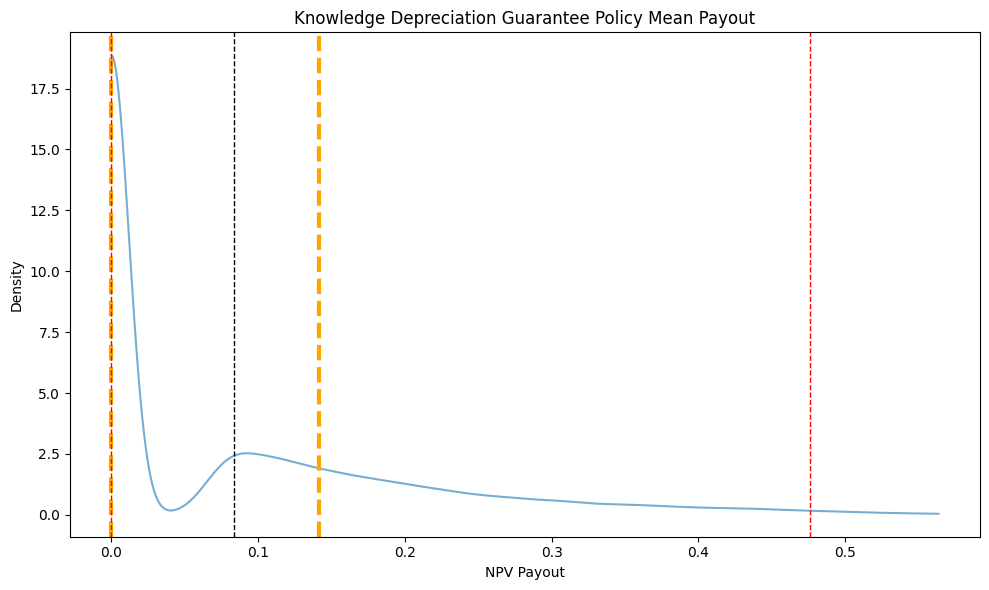

In [25]:
total_npv_payout_sims = kdg_results_dict['pv_paths']
total_npv_payout_sims_kde = stats.gaussian_kde(total_npv_payout_sims)

# Plot the Payout simulation means
plt.figure(figsize=(10, 6))
x = np.linspace(0, np.percentile(total_npv_payout_sims, 99.5) * 1.1, 1000)
plt.plot(x, total_npv_payout_sims_kde(x), alpha=0.6)
plt.axvline(total_npv_payout_sims.mean(), color='k', linestyle='dashed', linewidth=1)
# 50% CI
plt.axvline(np.percentile(total_npv_payout_sims, 25), color='orange', linestyle='dashed', linewidth=3)
plt.axvline(np.percentile(total_npv_payout_sims, 75), color='orange', linestyle='dashed', linewidth=3)
# 98% CI
plt.axvline(np.percentile(total_npv_payout_sims, 1), color='r', linestyle='dashed', linewidth=1)
plt.axvline(np.percentile(total_npv_payout_sims, 99), color='r', linestyle='dashed', linewidth=1)
plt.title('Knowledge Depreciation Guarantee Policy Mean Payout')
plt.xlabel('NPV Payout')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

### Pricing Flow
- **Exposure base:** initial index value $V_0$ or average over first quarter.
- **Loss distribution:** run Monte-Carlo on the full coupled system $(I, T, U)$ to get annual loss $L$.
- **Pure Premium:** $\mathbb{E}[L|\text{deductible, limit}]$
- **Risk Load:** $\text{Capital Cost + parametric risk on }\lambda, \alpha,\text{ etc.}$
- **Capital Cost:** $\text{CoC}\times\text{SCR (1-in-200 depreciation event)}=\text{CoC}\times\text{TVaR}_{99.5\%}$

In [41]:
utility_params = {
    'U0' : 0.75,
    'kappa' : 1.0,
    'U_bar' : 1.0,
    'sigma' : 0.15
}
starting_truth = 1.0
truth_params = {
    'erosion_shape' : 0.05,
    'restoration_shape' : 0.075,
    'shock_lambda' : 0.02,
    'shock_sigma' : 0.5,
    'shock_scale' : 0.1
}
replaceability = 1.0     # Cost to re-learn (1.0 is baseline, >1 is hard)
trigger_duration = 3.0   # in years
trigger_threshold = 0.30 # % drop over the duration
policy_years = 5.0       # in years
deductible = 0.20        # deductible as a % of initial value (0.0 to 1.0)
limit = 1.0              # limit as a % of initial value (0.0 to 1.0)
discount_rate = 0.045
n_sims = 100_000

kdg_results_dict = calculate_kdg_payout(utility_params,
                                        starting_truth,
                                        truth_params,
                                        replaceability,
                                        trigger_duration=trigger_duration,
                                        trigger_threshold=trigger_threshold,
                                        policy_years=policy_years,
                                        deductible=deductible,
                                        limit=limit,
                                        discount_rate=discount_rate,
                                        n_sims=n_sims)

cost_of_capital = 0.07
total_npv_payout_sims = kdg_results_dict['pv_paths']
pure_premium = kdg_results_dict['pure_premium']
VaR_99_5 = np.percentile(total_npv_payout_sims, 99.5)
parameter_risk = 0 # TODO: estimate
risk_margin = cost_of_capital * VaR_99_5
print("Initial Price: ", kdg_results_dict['initial_index'])
print("Pure Premium: ", pure_premium)
print("Risk Margin: ", risk_margin)

Initial Price:  0.7842608077667876
Pure Premium:  0.048715167340570416
Risk Margin:  0.03462466505767945


### Moral Hazard Levers
- **Parametric recoveries:** Payout is automatic when index hits strike; reduces disputes but forces transparent index constrction.
- **Evidence maintenance clause:** Require periodic replication or citation-audit. Non-compliance raises deductible.
- **Experience rating:** Post-loss surcharge on future premium if insured's own corrections lagged.
- **Co-insurance on *truth recovery* costs:** Insured shares 20-30% of replication spend to get skin in the game.
- **Real-time monitoring:** Pull citation velocity directly; premium credits for upward trends.

## Pricing Sketch ("Actuarial Cost of Truth")
- Exposure base: $\mathbb{E}[\text{NPV}]$.
- Frequency-Severity simulation of decay & shocks to get an annual loss distribution per $1 NPV.
- Risk load:
  - **Parametric Risk:** Baysian posterior on $p, \alpha, \lambda, \text{etc.}$, add a credibility margin.
  - **Model risk:** Stress alternate decau regimes (paradigm shift) and take Tail-VaR (e.g., 99.5th percentile).
- **Cost of Capital:** CoC * SCR (Solvency II-style). For intellectual assets, let SCR be driven by 1-in-200 utility collapse.
- **Premium:** $\text{Pure Premium}+\text{Risk Load}+\text{Expense}+\text{Profit}$.
  - $\Pi=\mathbb{E}[L]+k\text{TVaR}_{99.5\%}(L)+\text{Exp}+\text{Profit}$
  - $L$=simulated loss ratio.
  - $k\approx$ weighted average cost of capital.

## Implementation Sketch

1. Select corpus (DOI / arXiv IDs list) peer-reviewed
2. Baseline measurement
   - $U_0$ = citation_velocity(start)
   - $T_0$ = 1 (assumed peer-reviewed)
   - $V_0 = U_0\times T_0$
3. Monthly update loop:
   1. Pull new citations $\Delta U$
   2. Scrape retraction / erratum databases, shock arrivals $Z_i$
   3. Update $U_t$ via OU step
   4. Udate $D_t, J_t, \text{Recovery}_t$
   5. Compute $V_t=I_t\times U_t\times T_t$
   6. Check depreciation trigger
4. Premium refresh annually(?) with credibility-weighted posterior on $(\lambda,\kappa,\sigma_\text{U},\alpha_\text{drift},...)$.
   - Is this annually or every 5 years?

## Roadmap Post-Implementation
- **Calibrate U-process** from a sample of arXiv categories to get $\kappa$ and $\sigma_U$
- **Estimate shock severity** distribution Z from Retraction Watch data (lognormal heavy tail fits nicely).
- **Blend survival:** fit Kaplan-Meier to "time-to-major-revision" for textbooks or RFCs, then add a Pareto tail for the beyond-data horizon.
- **Prototype pricing:** small Python Month-Carlo for a single article's KDG with 30% trigger, 10% deductible, USD $1M limit.

## Portfolio Simulation Using Hierarchical Models

[10.46153916 15.25859266  8.82726362 10.07512392 14.33586021  9.65932333
 11.08369426 13.88871164  8.35560617  9.98212503 15.79085029 12.22365102
 13.97877166  9.90844383  9.62917916 10.17732337 16.17806138 10.05387201
  9.29781289 15.10399277  9.41592437  9.96454152 11.04721386 23.13671648
  9.98728008 25.37068142  8.95537487  9.21121262 16.12064852 13.94138014
 10.22576972 12.74636783 13.67951189  8.53174255 12.71157988  9.38711555
 11.24919558 14.58071831  9.76439441 16.67028422 12.98643881 13.44407895
  9.765068    9.5162937  21.49329533 12.18992788 13.77428672  9.47850818
  8.77603645 21.39677344 13.72837784  8.86656563 10.36835394 10.99594435
  9.61785329  9.23825886  9.32498377  9.87034474  9.23044172 10.16038438
 17.12754212  9.85982881  9.55409826  8.98765965 11.65687865  8.81800472
  9.00718942  9.63022223 10.78070444  8.43922144  9.95701327 15.26866041
 13.0943743  24.73084529 10.71036997  8.60151288 13.73537115 13.10719331
 12.81398836 10.41442995  9.63031447 21.68934748 11

C:\Users\alexf\AppData\Local\Temp\ipykernel_55264\1480908673.py:124: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best')


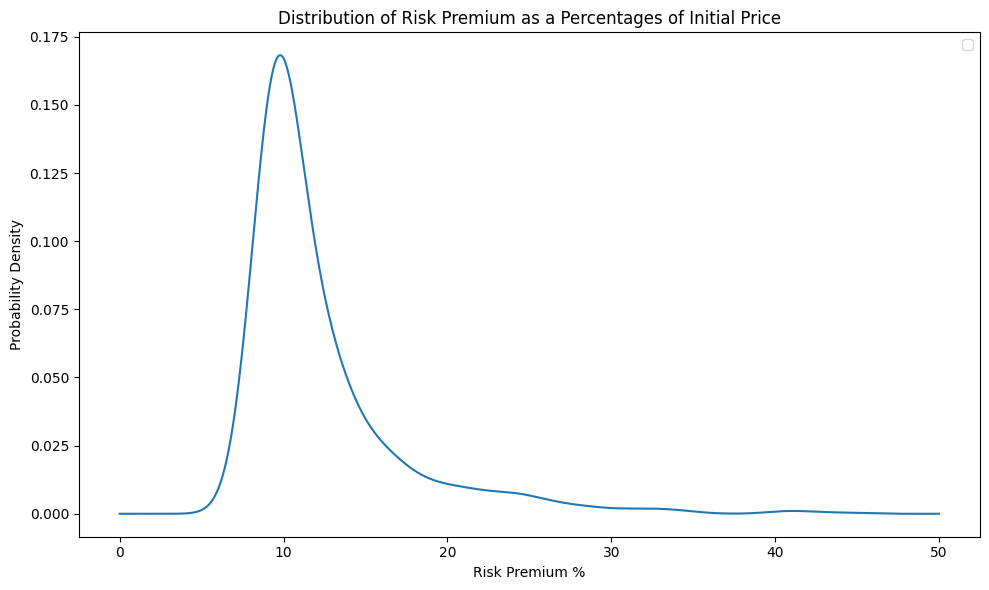

In [54]:
##########################
# Utility Hyperparameters
##########################
# U0 hyperparameters - normal
U0_mu = 0.75
U0_sigma = 0.1

# kappa hyperparameters - normal
kappa_mu = 1.0
kappa_sigma = 0.25

# U_bar hyperparameters - normal
U_bar_mu = 1.0
U_bar_sigma = 0.25

# sigma hyperparameters - normal
sigma_mu = 0.15
sigma_sigma = 0.05

########################
# Truth Hyperparameters
########################
# starting_truth hyperparameters - gamma
# Model: 1.0 - gamma(1.5, 0.1)
starting_truth_shape = 1.5
starting_truth_scale = 0.1

# erosion_shape hyperparameters - lognormal
erosion_shape_mu = np.log(0.05)
erosion_shape_sigma = 0.02 # TODO: figure this out

# restoration_shape hyperparameters - lognormal
restoration_shape_mu = np.log(0.075)
restoration_shape_sigma = 0.02 # TODO: figure this out

# shock_lambda hyperparameters - gamma
shock_lambda_shape = 1.5
shock_lambda_scale = 0.02 / 1.5

# shock_sigma hyperparameters - normal
shock_sigma_mu = 0.5
shock_sigma_sigma = 0.1

# shock_scale hyperparameters - normal
shock_scale_mu = 0.1
shock_scale_sigma = 0.02

#################################
# Replaceability Hyperparameters - lognormal
#################################
replaceability_mu = np.log(1.0)
replaceability_sigma = 0.25

#####################
# Policy Assumptions
#####################
trigger_duration = 3.0   # in years
trigger_threshold = 0.30 # % drop over the duration
policy_years = 5.0       # in years
deductible = 0.20        # deductible as a % of initial value (0.0 to 1.0)
limit = 1.0              # limit as a % of initial value (0.0 to 1.0)
discount_rate = 0.045
cost_of_capital = 0.07
n_sims = 100_000

n_assets = 1_000

rng = np.random.default_rng(42)

assets = {}
for i in range(n_assets):
    assets[i] = {
        'utility_params' : {
            'U0' : rng.normal(U0_mu, U0_sigma),
            'kappa' : rng.normal(kappa_mu, kappa_sigma),
            'U_bar' : rng.normal(U_bar_mu, U_bar_sigma),
            'sigma' : rng.normal(sigma_mu, sigma_sigma)
        },
        'starting_truth' : 1.0 - rng.gamma(starting_truth_shape, starting_truth_scale),
        'truth_params' : {
            'erosion_shape' : rng.lognormal(erosion_shape_mu, erosion_shape_sigma),
            'restoration_shape' : rng.lognormal(restoration_shape_mu, restoration_shape_sigma),
            'shock_lambda' : rng.gamma(shock_lambda_shape, shock_lambda_scale),
            'shock_sigma' : rng.normal(shock_sigma_mu, shock_sigma_sigma),
            'shock_scale' : rng.normal(shock_scale_mu, shock_scale_sigma)
        },
        'replaceability' : rng.lognormal(replaceability_mu, replaceability_sigma)
    }

initial_prices = np.zeros(n_assets)
pure_premiums = np.zeros(n_assets)
risk_margins = np.zeros(n_assets)
for i in range(n_assets):
    kdg_results_dict = calculate_kdg_payout(assets[i]['utility_params'],
                                            assets[i]['starting_truth'],
                                            assets[i]['truth_params'],
                                            assets[i]['replaceability'],
                                            trigger_duration=trigger_duration,
                                            trigger_threshold=trigger_threshold,
                                            policy_years=policy_years,
                                            deductible=deductible,
                                            limit=limit,
                                            discount_rate=discount_rate,
                                            n_sims=n_sims)
    
    total_npv_payout_sims = kdg_results_dict['pv_paths']
    pure_premium = kdg_results_dict['pure_premium']
    VaR_99_5 = np.percentile(total_npv_payout_sims, 99.5)
    parameter_risk = 0 # TODO: estimate
    risk_margin = cost_of_capital * VaR_99_5 + parameter_risk
    initial_prices[i] = kdg_results_dict['initial_index']
    pure_premiums[i] = pure_premium
    risk_margins[i] = risk_margin

risk_premium_pct = (pure_premiums + risk_margins) / initial_prices * 100.0
risk_premium_pct_kde = stats.gaussian_kde(risk_premium_pct)

print(risk_premium_pct)

# Plot the Risk Premium Percentage to assess viability
plt.figure(figsize=(10, 6))
x = np.linspace(0.0, 50.0, 1000)
plt.plot(x, risk_premium_pct_kde(x))
plt.legend(loc='best')
plt.title('Distribution of Risk Premium as a Percentages of Initial Price')
plt.xlabel('Risk Premium %')
plt.ylabel('Probability Density')
plt.tight_layout()
plt.show()